/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


Baseline Linear Regression Results:
Mean Squared Error: 0.1698
R^2 Score: 0.0988

XGBoost Regression Results:
Mean Squared Error: 0.1692
R^2 Score: 0.1017

[XGBoost] Predicted results for 50 users:
 ORIG BAL Predicted_ChargeOffRate Expected_Recovery
$3,817.80                  40.18%         $2,283.90
$4,053.24                  68.61%         $1,272.37
$4,053.24                  42.36%         $2,336.10
$3,824.64                  44.95%         $2,105.57
$3,535.92                  72.03%           $989.16
$2,379.60                  49.14%         $1,210.19
$4,273.56                  72.15%         $1,189.99
$4,053.24                  34.41%         $2,658.53
$4,422.24                  55.44%         $1,970.40
$2,287.80                  54.49%         $1,041.27
$2,971.08                  62.49%         $1,114.42
$4,160.16                  29.93%         $2,914.90
$1,859.04                  30.52%         $1,291.64
$7,290.72                  34.95%         $4,742.44
$3,425.04             

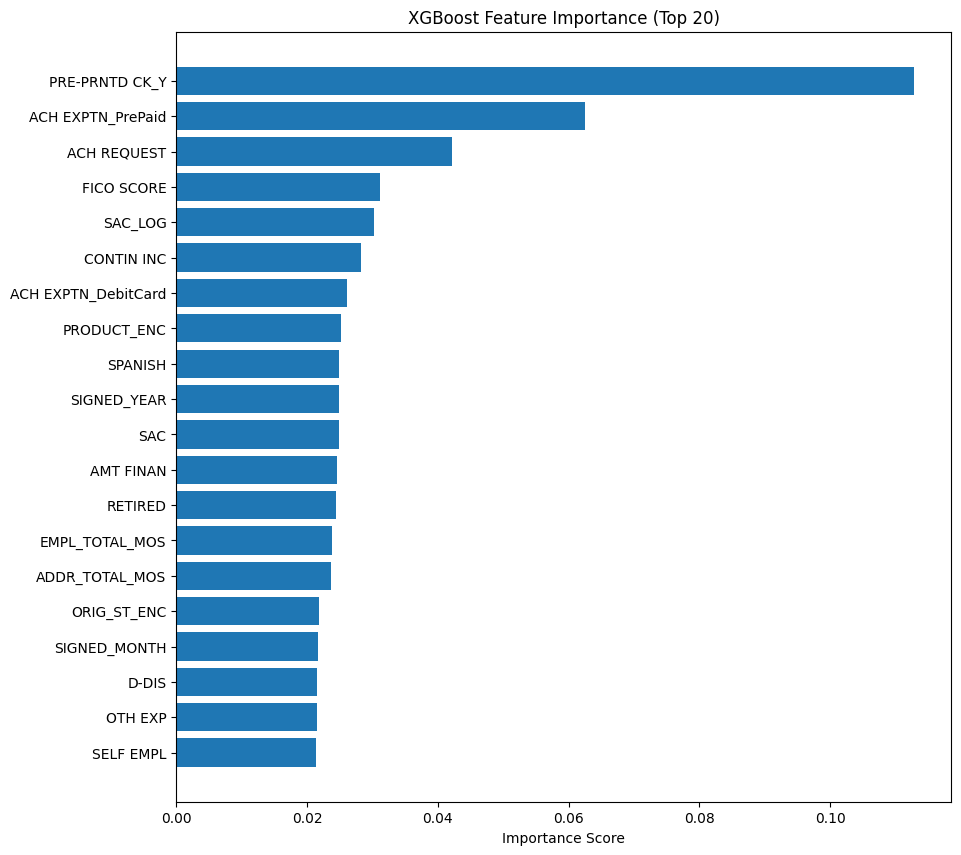

In [1]:
# =========================
# Step 1: Import Libraries
# =========================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor   # NEW
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# =========================
# Step 2: Load Dataset
# =========================
file_path = "/kaggle/input/trkcus-seasonal-adjustment-dataset-20152020/TRKCUS-01012015-02282020-SST ADJ CORRECTED.xlsx"
df = pd.read_excel(file_path)

# =========================
# Step 3: Feature Engineering (XGBoost version)
# =========================

# With the function of FICO SCORE
df = df[df["FICO SCORE"] != 1].copy()

# 3a. ChargeOffRate
df["ChargeOffRate"] = df["CO AMOUNT"] / df["ORIG BAL"]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["ChargeOffRate"])
df = df[df["ChargeOffRate"] >= 0]   # remove negatives only

# 3b. Dealer Code (first 4 chars)
df["DEALER CODE"] = df["DEALER CODE"].str[:-1].astype(int)
df["PRODUCT"] = df["PRODUCT"].str.strip().str.upper()
df["ORIG ST"] = df["ORIG ST"].str.strip().str.upper()

df["PRODUCT_ENC"] = le.fit_transform(df["PRODUCT"])
df["ORIG_ST_ENC"] = le.fit_transform(df["ORIG ST"])

# 3c. Boolean features: blanks/NaN → N → map to 0/1
binary_cols = [
    "DFRD PMT","SELF EMPL","RETIRED","MILITARY","CB SSN","PAY STUB",
    "RUSH APP","CKG ACCT EXTS","ACH REQUEST","CONTIN INC","OTH EXP",
    "REFERNCS","SPANISH","#OF ACSORY","I-DIS","D-DIS"
]
for col in binary_cols:
    df[col] = df[col].fillna("N").replace("", "N").map({"Y": 1, "N": 0})

# 3d. Employment & Address (yrs+mos → total months)
df["EMPL_TOTAL_MOS"] = df["EMPL YRS"].fillna(0) * 12 + df["EMPL MOS"].fillna(0)
df["ADDR_TOTAL_MOS"] = df["ADDR YRS"].fillna(0) * 12 + df["ADDR MOS"].fillna(0)

# 3d(i). Clip outliers in EMPL_TOTAL_MOS and ADDR_TOTAL_MOS
for col, max_cap in [("EMPL_TOTAL_MOS", 600),  # cap at 50 years
                     ("ADDR_TOTAL_MOS", 360)]: # cap at 30 years
    df[col] = df[col].clip(lower=0, upper=max_cap)

# 3e. Dates (APP DATE, SIGNED)
for col in ["APP DATE", "SIGNED"]:
    df[col] = df[col].replace("", np.nan)
    df[col] = pd.to_datetime(df[col], format="%Y%m%d", errors="coerce")

# Make sure APP DATE and SIGNED DATE are datetime
df["APP DATE"] = pd.to_datetime(df["APP DATE"])
df["SIGNED"] = pd.to_datetime(df["SIGNED"])

# Days difference (SIGNED - APP)
df["APP_SIGNED_DAYS"] = (df["SIGNED"] - df["APP DATE"]).dt.days
# Optional: handle invalid or extreme values
df["APP_SIGNED_DAYS"] = df["APP_SIGNED_DAYS"].clip(lower=0)  # no negatives
# Extract date parts
df["APP_YEAR"] = df["APP DATE"].dt.year.fillna(0).astype(int)
df["APP_MONTH"] = df["APP DATE"].dt.month.fillna(0).astype(int)
df["APP_DAYOFWEEK"] = df["APP DATE"].dt.dayofweek.fillna(0).astype(int)

df["SIGNED_YEAR"] = df["SIGNED"].dt.year.fillna(0).astype(int)
df["SIGNED_MONTH"] = df["SIGNED"].dt.month.fillna(0).astype(int)
df["SIGNED_DAYOFWEEK"] = df["SIGNED"].dt.dayofweek.fillna(0).astype(int)

df = df.drop(columns=["APP DATE","SIGNED"])  # drop raw dates

# 3f. SAC (Same-as-Cash promo)
df["SAC"] = pd.to_numeric(df["SAC"], errors="coerce").fillna(0)
df["SAC_LOG"] = np.log1p(df["SAC"])   # keep log-transform too

# 3g. PRE-ASSIGNED (blanks → N)
df["PRE-ASSIGNED"] = df["PRE-ASSIGNED"].fillna("N").replace("", "N")

# 3h. PRE-PRNTD CK (P → Y, blanks → N)
df["PRE-PRNTD CK"] = df["PRE-PRNTD CK"].replace("P", "Y").fillna("N").replace("", "N")

# 3i. ACH EXPTN (map codes to categories)
ach_map = {
    "C": "CreditCard",
    "D": "DebitCard",
    "N": "NoException",
    "P": "PrePaid",
    "Y": "ACH_Allowed_NoCheck"
}
df["ACH EXPTN"] = df["ACH EXPTN"].map(ach_map).fillna("NoException")

# One-hot encode PRE-ASSIGNED, PRE-PRNTD CK, ACH EXPTN
df = pd.get_dummies(df, columns=["PRE-ASSIGNED","PRE-PRNTD CK","ACH EXPTN"], drop_first=True)

# =========================
# Step 3b: Feature List (same as Linear Regression, but no scaling)
# =========================
features = [
    "FICO SCORE","DEALER CODE","CONTRACT TERM","INT RATE","AMT FINAN","DOWN","DFRD PMT",
    "SELF EMPL","EMPL_TOTAL_MOS","ADDR_TOTAL_MOS","AGE","RETIRED","PRODUCT_ENC","MILITARY","PAY STUB",
    "SAC","SAC_LOG","RUSH APP","ORIG_ST_ENC","APP_YEAR","APP_MONTH","APP_DAYOFWEEK",
    "CKG ACCT EXTS","ACH REQUEST","CONTIN INC","OTH EXP","REFERNCS","SPANISH","#OF ACSORY",
    "I-DIS","D-DIS","SIGNED_YEAR","SIGNED_MONTH","SIGNED_DAYOFWEEK","APP_SIGNED_DAYS",
    "PRE-ASSIGNED_Y","PRE-PRNTD CK_Y",
    "ACH EXPTN_CreditCard","ACH EXPTN_DebitCard","ACH EXPTN_PrePaid","ACH EXPTN_ACH_Allowed_NoCheck"
]
features = [col for col in features if col in df.columns]

# Convert features → numeric
for col in features:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.fillna(0)

# Final dataset
X = df[features]
y = df["ChargeOffRate"]


# =========================
# Step 4: Train-Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =========================
# Step 5a: Linear Regression Model
# =========================
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

# Evaluate XGBoost
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print("Baseline Linear Regression Results:")
print(f"Mean Squared Error: {mse_lin:.4f}")
print(f"R^2 Score: {r2_lin:.4f}")

# =========================
# Step 5b: XGBoost Regression Model
# =========================
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Regression Results:")
print(f"Mean Squared Error: {mse_xgb:.4f}")
print(f"R^2 Score: {r2_xgb:.4f}")

# =========================
# Step 6: Predictions for Business Cases
# =========================

# --- Case 1: 50 random users ---
sample_50 = df.sample(50, random_state=42).copy()
pred_50_xgb = xgb_model.predict(sample_50[features])

sample_50["Predicted_ChargeOffRate"] = pred_50_xgb
sample_50["Expected_Recovery"] = sample_50["ORIG BAL"] * (1 - sample_50["Predicted_ChargeOffRate"])

# Format results nicely
results_50 = sample_50[["ORIG BAL", "Predicted_ChargeOffRate", "Expected_Recovery"]].copy()
results_50["ORIG BAL"] = results_50["ORIG BAL"].apply(lambda x: f"${x:,.2f}")
results_50["Predicted_ChargeOffRate"] = results_50["Predicted_ChargeOffRate"].apply(lambda x: f"{x:.2%}")
results_50["Expected_Recovery"] = results_50["Expected_Recovery"].apply(lambda x: f"${x:,.2f}")

# Display results
print("\n[XGBoost] Predicted results for 50 users:")
print(results_50.to_string(index=False))

# Total recovery
# ---- Totals ----
total_orig_bal = sample_50["ORIG BAL"].sum()
avg_chargeoff_rate = sample_50["Predicted_ChargeOffRate"].mean()   # average instead of sum
total_recovery = sample_50["Expected_Recovery"].sum()

print("\n[XGBoost] Total results for 50 users:")
print(f"Original Balance: ${total_orig_bal:,.2f}")
print(f"Predicted ChargeOffRate (avg): {avg_chargeoff_rate:.2%}")
print(f"Expected Recovery: ${total_recovery:,.2f}")

# --- Case 2: Single user prediction ---
single_user = df.iloc[[0]]  # take first row as example
single_pred_xgb = xgb_model.predict(single_user[features])[0]
single_expected_recovery_xgb = single_user["ORIG BAL"].values[0] * (1 - single_pred_xgb)

print("\n[XGBoost] Single User Example:")
print(f"Original Balance: ${single_user['ORIG BAL'].values[0]:,.2f}")
print(f"Predicted ChargeOffRate: {single_pred_xgb:.2%}")
print(f"Expected Recovery: ${single_expected_recovery_xgb:,.2f}")
# =========================
# Step 7: Feature Importance (XGBoost)
# =========================
xgb_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
})

# Normalize importance (percentage contribution)
xgb_importance["Importance(%)"] = 100 * xgb_importance["Importance"] / xgb_importance["Importance"].sum()

# Sort by importance
xgb_importance = xgb_importance.sort_values("Importance", ascending=False).reset_index(drop=True)

# Add Rank column
xgb_importance.index += 1
xgb_importance.index.name = "Rank"

# Display top features
print("\nXGBoost Feature Importance (Top 20):")
print(xgb_importance.head(20))

# Plot (optional)
plt.figure(figsize=(10, 10))
plt.barh(xgb_importance["Feature"][:20], xgb_importance["Importance"][:20])
plt.xlabel("Importance Score")
plt.title("XGBoost Feature Importance (Top 20)")
plt.gca().invert_yaxis()
plt.show()


In [4]:
# =========================
# Step 8: Output Predictions on Test Set (XGBoost)
# =========================

# Get indices of test set back to original dataframe
test_results_xgb = df.loc[X_test.index].copy()

# Add actual + predicted
test_results_xgb["Actual_ChargeOffRate"] = y_test
test_results_xgb["Predicted_ChargeOffRate"] = y_pred_xgb  # raw numeric values

# Compute Expected Recovery = ORIG BAL * (1 - Predicted_ChargeOffRate)
test_results_xgb["Expected_Recovery"] = test_results_xgb["ORIG BAL"] * (1 - test_results_xgb["Predicted_ChargeOffRate"])


# Format predictions as percentages
test_results_xgb["Predicted_ChargeOffRate"] = test_results_xgb["Predicted_ChargeOffRate"].apply(lambda x: f"{x:.2%}")

# Show first few rows
len(test_results_xgb)

# test_results_xgb.head(10)

# test_results_xgb.shape

4092

In [3]:
test_results_xgb.to_excel("XGBoost-FN-of-FICO_results.xlsx", index=False)

# Move file to working directory so it appears in Kaggle output
import shutil
shutil.move("XGBoost-FN-of-FICO_results.xlsx", "/kaggle/working/XGBoost-FN-of-FICO_results.xlsx")

'/kaggle/working/XGBoost-FN-of-FICO_results.xlsx'